# TP3

## Integrantes

#### - Christopher Sebastian Charaf Herrera
#### - María Fabiana Cid
#### - Yessika Arrieta

TP3▪ Encontrar el logotipo de la gaseosa dentro de las imágenes provistas en Material TPs/TP3

### Images a partir del template Material_TPs/TP3/template

1. **(4 puntos)** Obtener una detección del logo en cada imagen sin falsos positivos.
2. **(4 puntos)** Plantear y validar un algoritmo para múltiples detecciones en la imagen `coca_multi.png` con el mismo template del ítem 1.
3. **(2 puntos)** Generalizar el algoritmo del ítem 2 para todas las imágenes. 

Visualizar los resultados con bounding boxes en cada imagen mostrando el nivel de confianza
de la detección.

In [1]:
#IMPORTS
%matplotlib inline

import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

## 1. **(4 puntos)** Obtener una detección del logo en cada imagen sin falsos positivos.

In [2]:
def template_matching(image, scale=1, method='cv.TM_CCOEFF', canny_threshold1=100, canny_threshold2=1100,thickness=2):
    """
    Perform template matching on the given image using the specified template, scale, method, and Canny thresholds.

    Parameters:
    template (numpy.ndarray): The template image.
    image (numpy.ndarray): The image in which to search for the template.
    scale (float): The scale factor to resize the template.
    method (str): The template matching method to use.
    canny_threshold1 (int): The first threshold for the hysteresis procedure in Canny edge detection.
    canny_threshold2 (int): The second threshold for the hysteresis procedure in Canny edge detection.

    Returns:
    result (numpy.ndarray): The result of the template matching.
    top_left (tuple): The top-left corner of the detected template in the image.
    bottom_right (tuple): The bottom-right corner of the detected template in the image.
    """

    template= cv.imread('./template/pattern.png',0)
    image= cv.imread(image)
    img_salida = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    # Apply Canny edge detection to both the template and the image
    template_edges = cv.Canny(template, threshold1=100, threshold2=500)
    image_edges = cv.Canny(image, threshold1=canny_threshold1, threshold2=canny_threshold2)

    # Resize the template according to the scale
    resized_template = cv.resize(template_edges, None, fx=scale, fy=scale)
    w, h = resized_template.shape[::-1]

    # Check if the resized template is larger than the image
    if resized_template.shape[0] > image_edges.shape[0] or resized_template.shape[1] > image_edges.shape[1]:
        raise ValueError("Resized template is larger than the image")

    # Convert method from string to actual OpenCV method
    method = eval(method)

    # Apply template matching
    result = cv.matchTemplate(image_edges, resized_template, method)

    # Find the minimum and maximum values and their locations
    min_val, max_val, min_loc, max_loc = cv.minMaxLoc(result)

    # Determine the top-left corner based on the method
    if method in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]:
        top_left = min_loc
    else:
        top_left = max_loc
                    
    # Marcamos
    bottom_right = (top_left[0] + w, top_left[1] + h)
    cv.rectangle(img_salida, top_left, bottom_right, (0,255,0), thickness)
    
    # Graficamos el procesamiento y la salida
    #----------------------------------------
    plt.figure()
    
    # Resultado de coincidencia
    plt.subplot(121), plt.imshow(result, cmap='gray')
    plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
    
    # Imagen original con recuadros
    plt.subplot(122), plt.imshow(img_salida)
    plt.title('Detected Point' + str(max_loc)), plt.xticks([]), plt.yticks([])
    plt.suptitle(f'{method} - Scale: {scale:.2f}')
    plt.show()

# Example usage:
# result, top_left, bottom_right = template_matching(template, img_gray, 0.5, 'cv.TM_CCOEFF', 100, 200)

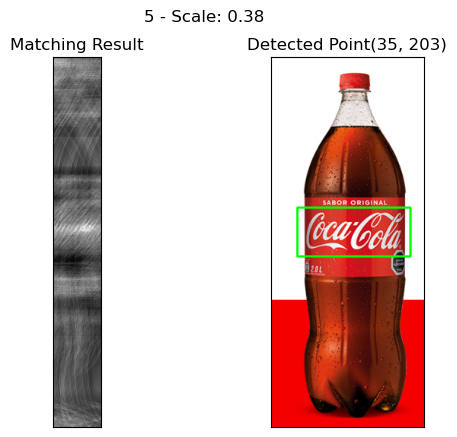

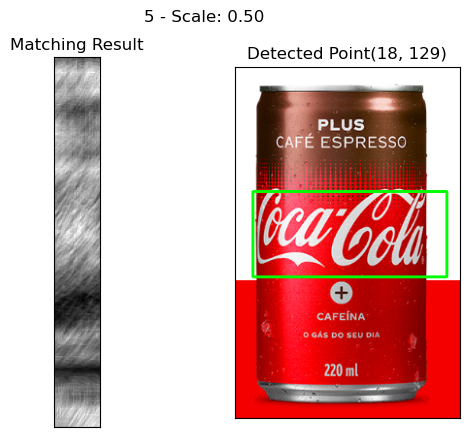

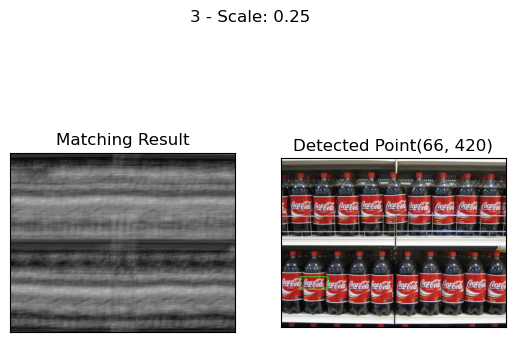

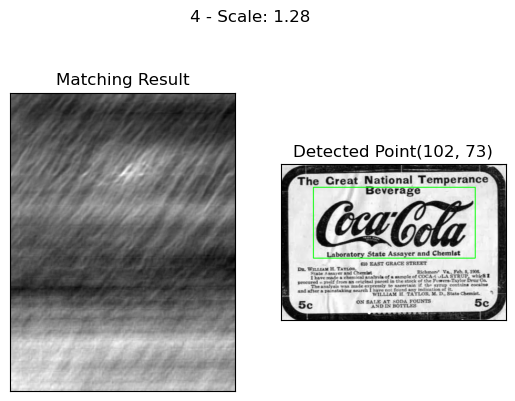

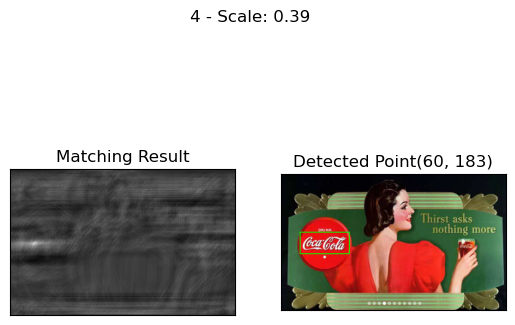

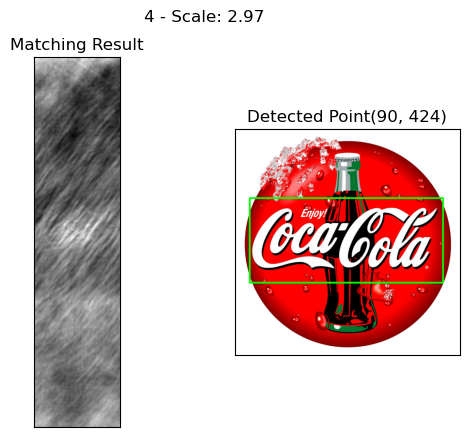

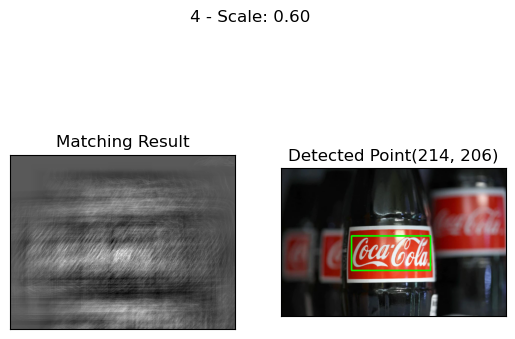

In [3]:
template_matching('./images/coca_logo_1.png',scale=0.38,method='cv.TM_CCOEFF_NORMED')
template_matching('./images/coca_logo_2.png',scale=0.50,method='cv.TM_CCOEFF_NORMED')
template_matching('./images/coca_multi.png',scale=0.25,method='cv.TM_CCORR_NORMED',canny_threshold1=100,canny_threshold2=200)
template_matching('./images/coca_retro_1.png',scale=1.28,method='cv.TM_CCOEFF',canny_threshold1=100,canny_threshold2=200)
template_matching('./images/coca_retro_2.png',scale=0.39,method='cv.TM_CCOEFF',canny_threshold1=100,canny_threshold2=200)
template_matching('./images/COCA-COLA-LOGO.jpg',scale=2.97,method='cv.TM_CCOEFF',canny_threshold1=100,canny_threshold2=200,thickness=10)
template_matching('./images/logo_1.png',scale=0.60,method='cv.TM_CCOEFF',canny_threshold2=200,thickness=4)

## 2. **(4 puntos)** Plantear y validar un algoritmo para múltiples detecciones en la imagen `coca_multi.png` con el mismo template del ítem 1.

In [4]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt


def multi_template_matching(template_path, image_path, scale=1, method='cv.TM_CCOEFF', canny_threshold1=100, canny_threshold2=200, threshold=0.8):
    """
    Detect multiple instances of a template in the given image using template matching.

    Parameters:
    template_path (str): The path to the template image.
    image_path (str): The path to the image in which to search for the template.
    scale (float): The scale factor to resize the template.
    method (str): The template matching method to use.
    canny_threshold1 (int): The first threshold for Canny edge detection.
    canny_threshold2 (int): The second threshold for Canny edge detection.
    threshold (float): Minimum similarity threshold for a detection to be considered valid.

    Returns:
    bboxes (list): List of bounding boxes around detected templates.
    """

    # Cargar las imágenes
    template = cv.imread(template_path, cv.IMREAD_GRAYSCALE)
    image = cv.imread(image_path)
    
    img_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)

    # Aplicar detección de bordes Canny al template y a la imagen
    template_edges = cv.Canny(template, threshold1=canny_threshold1, threshold2=300)
    image_edges = cv.Canny(image, threshold1=canny_threshold1, threshold2=canny_threshold2)

    # Redimensionar el template según la escala
    resized_template = cv.resize(template_edges, None, fx=scale, fy=scale)
    w, h = resized_template.shape[::-1]

    # Verificar si el template redimensionado es más grande que la imagen
    if resized_template.shape[0] > image_edges.shape[0] or resized_template.shape[1] > image_edges.shape[1]:
        raise ValueError("Resized template is larger than the image")

    # Convertir el método de string a método OpenCV
    if method not in METHODS:
        raise ValueError(f"Método {method} no reconocido. Usa uno de los siguientes: {list(METHODS.keys())}")
    method = eval(method)

    # Aplicar coincidencia de plantillas
    result = cv.matchTemplate(image_edges, resized_template, method)

    # Encontrar los valores mínimos y máximos y sus ubicaciones
    min_val, max_val, min_loc, max_loc = cv.minMaxLoc(result)

    # Filtramos las coincidencias que superan el umbral
    yloc, xloc = np.where(result >= threshold * max_val)

    # Creamos una lista de bounding boxes
    bboxes = []
    for (x, y) in zip(xloc, yloc):
        bboxes.append([x, y, x + w, y + h, max_val])

    # Aplicamos supresión de no máximos para evitar detecciones superpuestas
    bboxes = np.array(bboxes)
    if len(bboxes) > 0:
        bboxes = non_max_suppression_fast(bboxes, overlapThresh=0.3)

    # Dibujamos los rectángulos en la imagen original
    for (x1, y1, x2, y2, _) in bboxes:
        cv.rectangle(img_rgb, (x1, y1), (x2, y2), (0, 255, 0), 2)

    # Mostrar la imagen con las detecciones
    plt.figure(figsize=(12, 6))
    plt.imshow(img_rgb)
    plt.title("Detected Templates")
    plt.axis("off")
    plt.show()

    return bboxes





In [5]:
bboxes = multi_template_matching('./template/pattern.png', './images/coca_multi.png', scale=0.25, method='cv.TM_CCOEFF',canny_threshold1=100, canny_threshold2=200, threshold=0.55)


NameError: name 'METHODS' is not defined

## 3. **(2 puntos)** Generalizar el algoritmo del item 2 para todas las imágenes.

In [ ]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# Diccionario de métodos de coincidencia seguros
METHODS = {
    "cv.TM_CCOEFF": cv.TM_CCOEFF,
    "cv.TM_CCOEFF_NORMED": cv.TM_CCOEFF_NORMED,
    "cv.TM_CCORR": cv.TM_CCORR,
    "cv.TM_CCORR_NORMED": cv.TM_CCORR_NORMED,
    "cv.TM_SQDIFF": cv.TM_SQDIFF,
    "cv.TM_SQDIFF_NORMED": cv.TM_SQDIFF_NORMED
}

def auto_canny(image, sigma=0.33):
    """Función para calcular los umbrales de Canny automáticamente"""
    v = np.median(image)
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv.Canny(image, lower, upper)
    return edged

def multi_template_matching_images(template_path, image_path, scales=[1], method='cv.TM_CCOEFF', threshold=0.8):
    """
    Generalized multi-scale template matching algorithm for all types of images.

    Parameters:
    template_path (str): Path to the template image.
    image_path (str): Path to the image in which to search for the template.
    scales (list): List of scales to resize the template for multi-scale detection.
    method (str): Template matching method to use.
    threshold (float): Minimum similarity threshold for a detection to be considered valid.

    Returns:
    bboxes (list): List of bounding boxes around detected templates.
    """

    # Cargar las imágenes
    template = cv.imread(template_path, cv.IMREAD_GRAYSCALE)
    image = cv.imread(image_path)

    # Verificar si la imagen es en color y convertirla a escala de grises si es necesario
    if len(image.shape) == 3:  # Imagen en color
        gray_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    else:
        gray_image = image

    img_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)

    # Aplicar detección de bordes Canny automática al template y a la imagen
    template_edges = auto_canny(template)
    image_edges = auto_canny(gray_image)

    bboxes = []

    for scale in scales:
        # Redimensionar el template según la escala
        resized_template = cv.resize(template_edges, None, fx=scale, fy=scale)
        w, h = resized_template.shape[::-1]

        # Verificar si el template redimensionado es más grande que la imagen
        if resized_template.shape[0] > image_edges.shape[0] or resized_template.shape[1] > image_edges.shape[1]:
            continue  # Saltar si el template redimensionado es más grande que la imagen

        # Convertir el método de string a método OpenCV usando el diccionario seguro
        if method not in METHODS:
            raise ValueError(f"Método {method} no reconocido. Usa uno de los siguientes: {list(METHODS.keys())}")
        method_opencv = METHODS[method]

        # Aplicar coincidencia de plantillas
        result = cv.matchTemplate(image_edges, resized_template, method_opencv)

        # Filtrar las coincidencias que superan el umbral
        min_val, max_val, min_loc, max_loc = cv.minMaxLoc(result)
        yloc, xloc = np.where(result >= threshold * max_val)

        # Crear una lista de bounding boxes
        for (x, y) in zip(xloc, yloc):
            bboxes.append([x, y, x + w, y + h, max_val])

    # Aplicar supresión de no máximos para evitar detecciones superpuestas
    bboxes = np.array(bboxes)
    if len(bboxes) > 0:
        bboxes = non_max_suppression_fast(bboxes, overlapThresh=0.3)

    # Dibujar los rectángulos en la imagen original
    for (x1, y1, x2, y2, _) in bboxes:
        cv.rectangle(img_rgb, (x1, y1), (x2, y2), (0, 255, 0), 2)

    # Mostrar la imagen con las detecciones
    plt.figure(figsize=(12, 6))
    plt.imshow(img_rgb)
    plt.title("Detected Templates")
    plt.axis("off")
    plt.show()

    return bboxes

#def non_max_suppression_fast(boxes, overlapThresh=0.3):
#    if len(boxes) == 0:
#        return []
#
#    # Inicializar las listas de coordenadas
#    pick = []
#
#    # Extraer las coordenadas
#    x1 = boxes[:, 0]
#    y1 = boxes[:, 1]
#    x2 = boxes[:, 2]
#    y2 = boxes[:, 3]
#
#    # Calcular el área de las cajas
#    area = (x2 - x1 + 1) * (y2 - y1 + 1)
#    
#    # Ordenar las cajas por la coordenada de abajo a la derecha
#    idxs = np.argsort(boxes[:, 4])
#
#    while len(idxs) > 0:
#        last = len(idxs) - 1
#        i = idxs[last]
#      pick.append(i)
#
#      # Encontrar las coordenadas máximas de la intersección
#      xx1 = np.maximum(x1[i], x1[idxs[:last]])
#      yy1 = np.maximum(y1[i], y1[idxs[:last]])
#      xx2 = np.minimum(x2[i], x2[idxs[:last]])
#      yy2 = np.minimum(y2[i], y2[idxs[:last]])
#
#      # Calcular el ancho y alto de la intersección
#      w = np.maximum(0, xx2 - xx1 + 1)
#      h = np.maximum(0, yy2 - yy1 + 1)
#
#      # Calcular la relación de intersección sobre la unión
#      overlap = (w * h) / area[idxs[:last]]
#
#      # Eliminar todas las cajas que tienen un umbral de intersección superior al de overlapThresh
#      idxs = np.delete(idxs, np.concatenate(([last], np.where(overlap > overlapThresh)[0])))
#
#    return boxes[pick].astype("int")


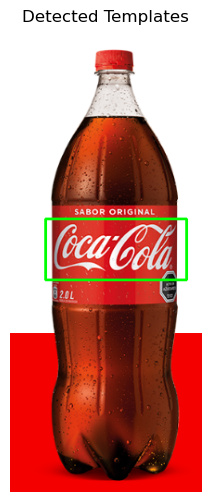

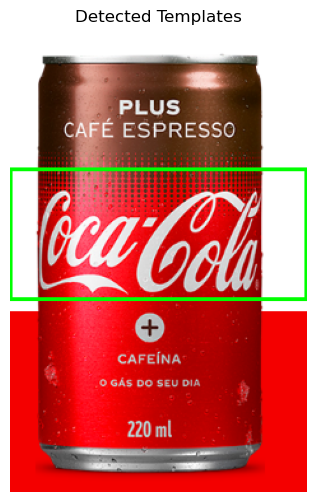

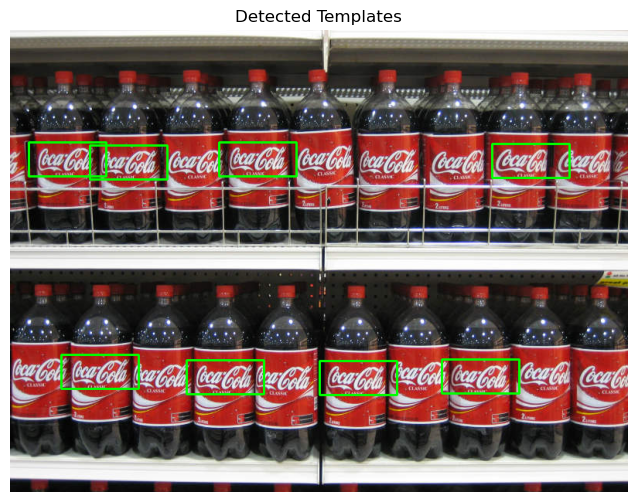

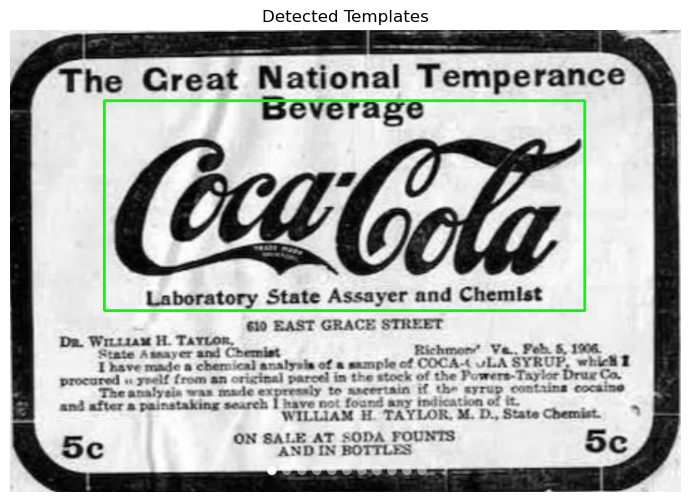

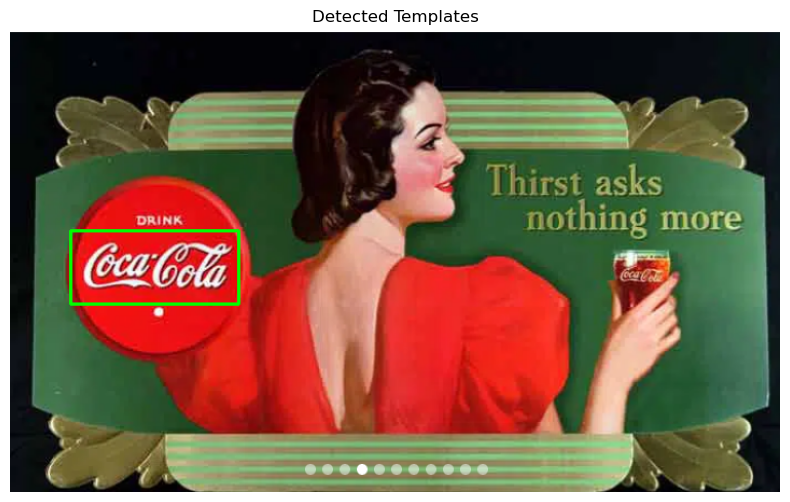

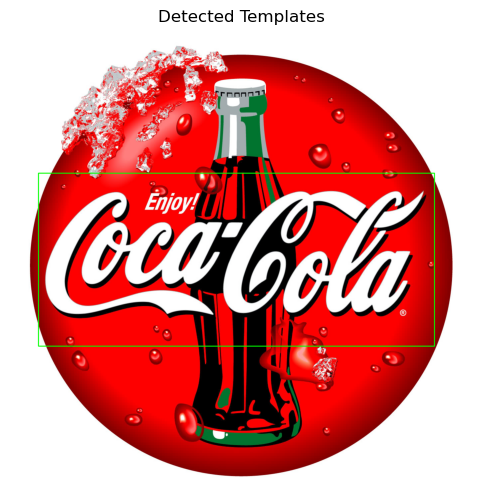

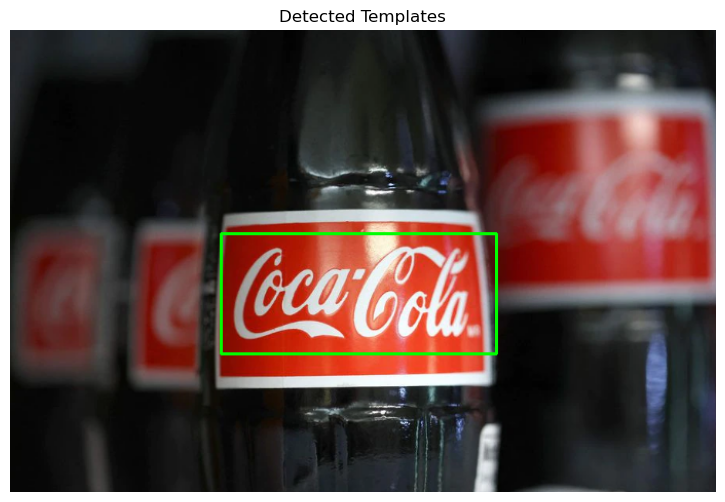

array([[     205,      198,      473,      315, 10474997]])

In [ ]:
multi_template_matching_images('./template/pattern.png','./images/coca_logo_1.png',scales=[0.38],method='cv.TM_CCOEFF_NORMED')
multi_template_matching_images('./template/pattern.png', './images/coca_logo_2.png', scales=[0.58], method='cv.TM_CCOEFF', threshold=0.60)
multi_template_matching_images('./template/pattern.png','./images/coca_multi.png' ,scales=[0.25],method='cv.TM_CCOEFF_NORMED')
multi_template_matching_images('./template/pattern.png', 'images/coca_retro_1.png', scales=[1.28], method='cv.TM_CCOEFF_NORMED', threshold=0.85)
multi_template_matching_images('./template/pattern.png','./images/coca_retro_2.png',scales=[0.39],method='cv.TM_CCOEFF')
multi_template_matching_images('./template/pattern.png', './images/COCA-COLA-LOGO.jpg', scales=[2.97], method='cv.TM_CCOEFF_NORMED', threshold=0.85)
multi_template_matching_images('./template/pattern.png', './images/logo_1.png', scales=[0.67], method='cv.TM_CCOEFF', threshold=0.95)

In [ ]:
scales=[0.38, 0.58, 0.25, 1.28, 0.39, 2.97, 0.67]

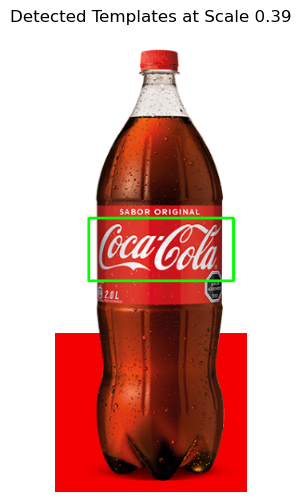

(array([[ 36, 203, 192, 271,   0]]), 0.39)

In [ ]:
multi_template_matching_images('./template/pattern.png','./images/coca_logo_1.png', scales, method='cv.TM_CCOEFF_NORMED', threshold=0.8)